# Contents
- [Read Me](#ReadMe)
- [Helper Functions](#HelperFunctions)
<br>
- [Numerical Integration Methods](#NumericalIntegration)
    - Extended Trapezium Rule
    - Extended Simpson's Rule
    - Numerical Integration 
    - Error Convergence
- [Monte Carlo Methods](#MonteCarlo)
    - Sample Distributions
    - Monte Carlo Integration (Uniform & Importance Sampling)
    - Metropolis Method
    - MC Methods Results
    - Error Convergence
    - Estimated Samples Required for Target Errors
- [Validations](#validation)
    - Numerical Results
    - Distributions

## Read Me <a id='ReadMe'>

This notebook file is written with the intention to solve the problems posed in Question 2. The python PEP 8 standard is used as a stylistic guide. The notebook is split into several parts: helper functions contain miscellaneous code used throughout, numerical integration methods contain functions for part (a), Monte Carlo methods for part (b), and validations of numerical results. Boxes should be run sequentially, and several MC simulations can take a lengthy period of time to complete.

Calculations are predominantly done in numpy arrays, and graph plotting in matplotlib. Pandas DataFrames are used to manipulate and display results. In the Monte Carlo methods, calculations are vectorised where possible in the interest of efficiency. This means 'batches' of random numbers are used for every iteration.

## Helper functions <a id='HelperFunctions'>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.integrate
import timeit
import pandas as pd
np.random.seed(1234)
params = { 'axes.labelsize': 16,
           'axes.titlesize': 20,
           'xtick.labelsize': 12,
           'ytick.labelsize': 12,
           'figure.figsize': [9, 4],
           'figure.dpi': 150,
           'figure.titlesize': 20,
           'grid.linewidth':0.5, 
           'legend.fontsize': 14}
plt.rcParams.update(params)

In [2]:
#Function to be integrated in question
def psi_sq(x):
    return np.pi**-0.5 * np.exp(-x**2)

#Sorts arrays x and y such that x is ascending
def check_sorted(x,y):
    if np.any(np.diff(x)<0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]
    return x,y

#Count function iterations assuming points are doubled each iteration
def count_iterations(x):
    return int(np.log2(len(x)))

## Numerical Integration Methods <a id='NumericalIntegration'>
### Extended Trapezoidal Rule

In [3]:
#Main function
def trap_extended(function=psi_sq, a=0, b=2, e=1e-6):
    x = np.array([b, a])
    y = np.array([function(b), function(a)])
    h = b - a
    output = []
    err = e + 1    #Ensures first error check fails
    i1 = trap_area(y, h)
    iteration = 1
    while err > e:
        iteration += 1
        #Adds intermediate points
        x, y, h = add_pts(function, x, y, h)
        i2 = trap_area(y, h)
        err = abs((i2 - i1) / i1)
        output.append([i2, err, iteration])
        i1 = i2
    return np.array(output)

#Adds (n-1) intermediate points
def add_pts(function, x, y, h):
    h /= 2
    #Adds a new point after new width after every existing point
    x_new = x[1:] + h
    x = np.append(x, x_new)
    y = np.append(y, function(x_new))
    return x, y, h

#Formula for summing all areas 
def trap_area(y, h):
    area = h * (np.sum(y) - 0.5*(y[0] + y[1]))
    return area

### Extended Simpson Rule

In [4]:
#Main function
def simp_extended(function=psi_sq, a=0, b=2, e=1e-6):
    x = np.array([b, a])
    y = np.array([function(b), function(a)])
    h = b - a
    output = []
    err = e + 1    #Ensures first error check fails
    #Keep new Trap area to prevent re-calculation
    t1 = trap_area(y, h)
    i1, t1, x, y, h = simp_area(function, t1, x, y, h)
    iteration = 1
    while err > e:
        iteration += 1
        i2, t1, x, y, h = simp_area(function, t1, x, y, h)
        err = abs((i2 - i1) / i1)
        output.append([i2, err, iteration])
        i1 = i2
    return np.array(output)

#Add intermediate points, calculate next t and update area
def simp_area(function, t1, x, y, h):
    x, y, h = add_pts(function, x, y, h)
    t2 = trap_area(y, h)
    #Formula to calculate Simpson's area from Trapezium area
    i1 = (4 * t2 - t1) / 3
    return i1, t2, x, y, h

### Numerical Integration Results

In [5]:
#Create table of integral values, errors and function iterations
head = ['integral', 'error', 'iterations']
trap_df = pd.DataFrame(trap_extended(psi_sq, 0, 2, 1e-6), columns = head)
simp_df = pd.DataFrame(simp_extended(psi_sq, 0, 2, 1e-6), columns = head)
trap_df['samples'] = np.power(2, trap_df['iterations'])+1
simp_df['samples'] = np.power(2, simp_df['iterations'])+1
trap_df['rule'] = 'Trapezium'
simp_df['rule'] = "Simpson's"
NM_results = pd.concat([trap_df, simp_df])
NM_results

,integral,error,iterations,samples,rule
0,0.494815,1.387373e-01,2.0,5.0,Trapezium
1,0.496836,4.083491e-03,3.0,9.0,Trapezium
2,0.497448,1.232267e-03,4.0,17.0,Trapezium
3,0.497607,3.203501e-04,5.0,33.0,Trapezium
4,0.497648,8.085448e-05,6.0,65.0,Trapezium
5,0.497658,2.026150e-05,7.0,129.0,Trapezium
6,0.497660,5.068367e-06,8.0,257.0,Trapezium
7,0.497661,1.267279e-06,9.0,513.0,Trapezium
8,0.497661,3.168313e-07,10.0,1025.0,Trapezium
0,0.497509,6.249570e-02,2.0,5.0,Simpson's


### Error covergence

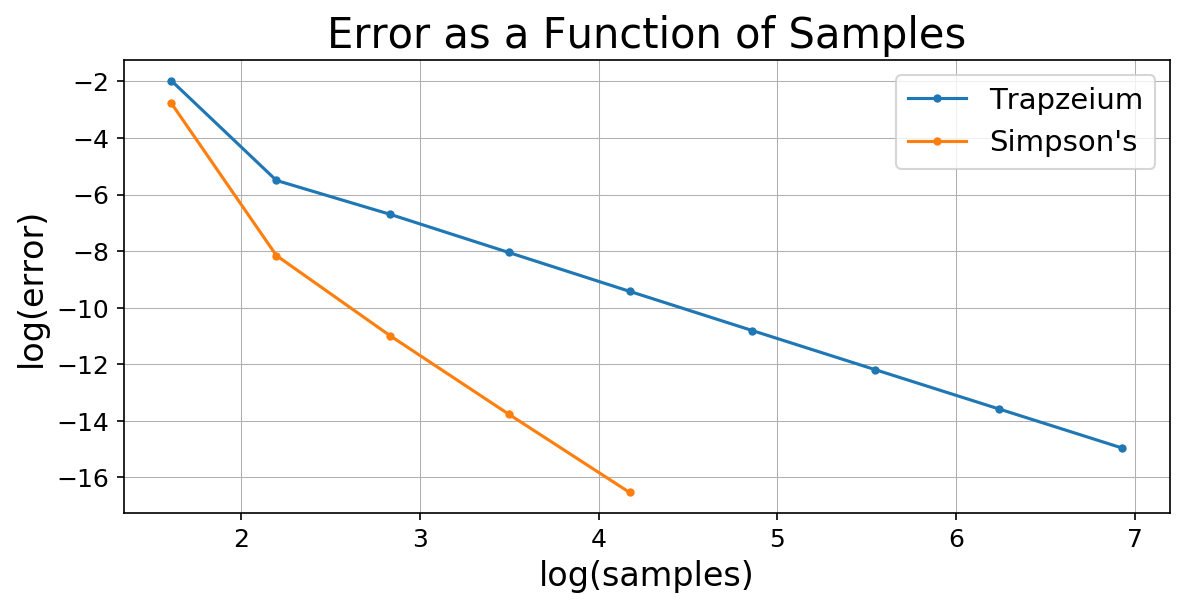

--- Trapzeium Method ---
LinregressResult(slope=-2.007490907252443, intercept=-1.0467239068903904, rvalue=-0.999976885525862, pvalue=3.087340516592225e-14, stderr=0.005572402741781221)
--- Simpson's Method ---
LinregressResult(slope=-4.229851455975693, intercept=1.071361635740864, rvalue=-0.9998092569527669, pvalue=0.00019074304723309948, stderr=0.05842673398428834)


In [6]:
trap_df[['log_error', 'log_samples']] = np.log(trap_df[['error', 'samples']])
simp_df[['log_error', 'log_samples']] = np.log(simp_df[['error', 'samples']])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(trap_df['log_samples'], trap_df['log_error'], label='Trapzeium', marker='o', ms=3)
ax.plot(simp_df['log_samples'], simp_df['log_error'], label="Simpson's", marker='o', ms=3)
ax.set_xlabel('log(samples)')
ax.set_ylabel('log(error)')
ax.set_title('Error as a Function of Samples')
plt.grid()
plt.legend()
plt.savefig('err_quad.png', bbox_inches='tight')
plt.show()
#Calculate gradient
grad_trap = scipy.stats.linregress(trap_df['log_samples'][1:], trap_df['log_error'][1:])
grad_simp = scipy.stats.linregress(simp_df['log_samples'][1:], simp_df['log_error'][1:])
print('--- Trapzeium Method ---')
print(grad_trap)
print("--- Simpson's Method ---")
print(grad_simp)

Trapezium method has a gradient of ~ -2 as expected, but Simpson's method has a gradient of ~-4.2, slightly deviating from the expected -4

## Monte Carlo Methods <a id='MonteCarlo'>

### Sample distributions
Possible sampling distributions with integrand

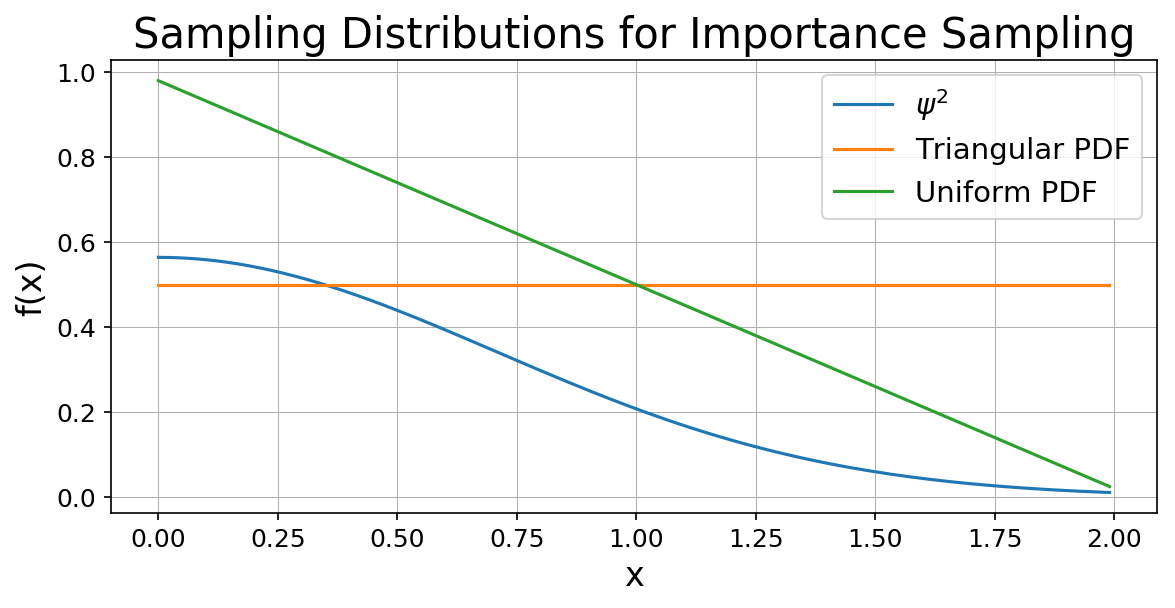

In [7]:
#Uniform distribution
def P_uniform(x, a=0, b=2):
    y = np.ones(len(x)) / 2
    y[(x < a) | (x > b)]= 0
    return y

#Triangular Distribution
def P_tri(x, a=0, b=2):
    y = -0.48 * x + 0.98
    y[(x < a) | (x > b)]= 0
    return y
    
#Plot the function to be integrated with 2 sampling distribution
x = np.arange(0, 2, 0.01)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_sq(x), label='$\psi^{2}$')
ax.plot(x, P_uniform(x, 0, 2), label='Triangular PDF')
ax.plot(x, P_tri(x, 0, 2), label='Uniform PDF')
ax.set_title('Sampling Distributions for Importance Sampling')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid()
plt.savefig('sampling_pdf.png', bbox_inches='tight')
plt.show()


### Monte Carlo Integration

In [9]:
#Main function. Evaluates function integrated from a to b with error 
#smaller than e and using pre-defined sampling distribution 
def mc_int(sampling, sampler, function=psi_sq, a=0, b=2, e=1e-6, n=1e4):
    n = int(n)
    L = b-a
    I = np.array([])
    f_values = np.array([])
    I_samples = np.array([0])
    I_err = np.array([e+1])
    while I_err[-1] > e:
        #Generate n random samples and add them to sum and variance
        I, I_err, f_values = update_sum_var(I, I_err, f_values, function, n, L, sampling, sampler)
        I_samples = np.append(I_samples, I_samples[-1] + n)
        n *= 2
    #Removes the first value added during initialisation
    I_samples = I_samples[1:]
    I_err = I_err[1:]
    return pd.DataFrame({'integral': I, 'error': I_err, 'samples': I_samples})

#Helper function that generates n new samples and updates sum and var
def update_sum_var(I, I_err, f_values, function, n, L, sampling, sampler):
    #Generates n random samples
    x = sampler(np.random.rand(n))
    f_values = np.append(f_values, function(x) / sampling(x))
    #Adds the mean and err
    I = np.append(I, np.mean(f_values))
    I_err = np.append(I_err, L * np.sqrt(np.var(f_values, ddof=1) / len(f_values)))
    return I, I_err, f_values

#Tranformation method to generate samples from a triangular distribution
def tri_transform(x, a=-0.48, b=0.98):
    b_a = b / a
    #Find sign of solution
    sign = b_a / abs(b_a)
    return sign * np.sqrt(2*x/a + b_a**2) - b_a

#Uniform distribution from 0 to 2
def uniform_sampler(x):
    return 2 * x

In [10]:
#This takes a while
uni = mc_int(P_uniform, uniform_sampler, psi_sq, 0, 2, 1e-4, n=1e5)
uni['sampler'] = 'uniform'
uni['log_samples'] = np.log(uni['samples'])
tri = mc_int(P_tri, tri_transform, psi_sq, 0, 2, 1e-5, n=1e5)
tri['sampler'] = 'triangular'
tri['log_samples'] = np.log(tri['samples'])

### Metropolis Algorithm

In [11]:
#Functions for P and Q such that P is a pdf and P.Q = Psi_sq
def psi_P(x, scaling=2):
    output = np.exp(-(x**2)/2) / (np.sqrt(2*np.pi) * scaling)
    output[(x < 0) | (x > 2)] = 0
    return output

def psi_Q(x, scaling=2):
    return np.exp(-(x**2)/2) * np.sqrt(2) * scaling

In [12]:
#Metropolis algorithm where Q.P is integrated from a to b to obtain <Q>, where
#P is a PDF. e is upper bound on error, and starting_pts is the number of starting 
#points to take. n is the number of steps to take for each batch of iterations.
def metropolis(Q, a, b, P, e, starting_pts, n):
    starting_pts = int(starting_pts)
    n = int(n)
    Q_values = np.array([])
    Q_means = np.array([])
    x_values = np.array([])
    errors = np.array([])
    samples = np.array([])
    #Scaling factor to ensure P is a pdf across range a to b
    scaling = scipy.stats.norm.cdf(b) - scipy.stats.norm.cdf(a)
    err = e + 1
    step = 10 * (a - b) / n
    x0 = np.linspace(a, b, starting_pts).reshape((starting_pts, ))
    iteration = 0
    while err > e:
        #Generates array of random steps
        dx = 2 * (np.random.random((starting_pts, n))-0.5) * (b-a)
        for i in range(n):
            x1 = np.add(x0, dx[:,i])
            #Acceptance probability of P
            P_acc = np.divide(P(x1, scaling), P(x0, scaling))
            #Random numbers to determine acceptance
            R = np.random.random((starting_pts,))
            #Boolean mask for accepted x1
            x_acc = P_acc > R
            x0[x_acc] = x1[x_acc]
            Q_values = np.append(Q_values, Q(x0, scaling))
            x_values = np.append(x_values, [x0])
        #Discard the first iteration of n samples due to burn-in
        if iteration == 0:
            Q_values = np.array([])
            x_values = np.array([])
        else:
            err = np.std(Q_values) / np.sqrt(len(Q_values))
            errors = np.append(errors, err)
            Q_means = np.append(Q_means, np.mean(Q_values))
            samples = np.append(samples, len(Q_values))
        iteration += 1
    results_df = pd.DataFrame({'integral': Q_means, 'error': errors,
                               'samples': samples})
    return results_df, x_values

In [14]:
#This takes a while (>15min)
met, met_x = metropolis(psi_Q, 0, 2, psi_P, 1e-4, 10, 1e4)
met['sampler'] = 'Metropolis'

### MC Methods Results

In [15]:
#Generate result table showing results from MC methods for the target errors.
errors = [1e-3, 1e-4]
uni_err = pd.concat([uni[uni['error']<e].iloc[[0]] for e in errors], ignore_index=True)
tri_err = pd.concat([tri[tri['error']<e].iloc[[0]] for e in [1e-3, 1e-4, 1e-5]], ignore_index=True)
met_err = pd.concat([met[met['error']<e].iloc[[0]] for e in errors], ignore_index=True)
MC_err = pd.concat([uni_err, tri_err, met_err])
MC_err

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,error,integral,log_samples,sampler,samples
0,0.000930,0.497716,13.458836,uniform,700000.0
1,0.000077,0.497657,18.443420,uniform,102300000.0
0,0.000853,0.497424,11.512925,triangular,100000.0
1,0.000076,0.497650,16.357113,triangular,12700000.0
2,0.000009,0.497665,20.523717,triangular,819100000.0
0,0.000527,0.497123,NaN,Metropolis,100000.0
1,0.000099,0.497793,NaN,Metropolis,2800000.0


### Error Convergence

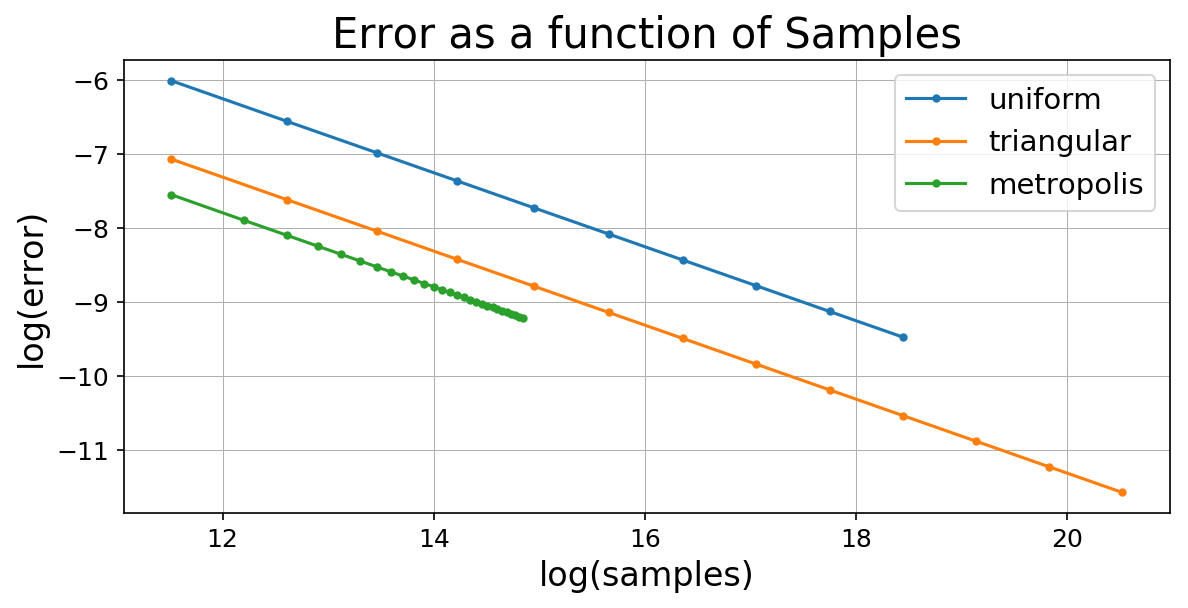

--- Uniform Sampling ---
LinregressResult(slope=-0.4999993899410119, intercept=-0.25132884356392804, rvalue=-0.9999999747063638, pvalue=1.79070115738838e-30, stderr=3.975988509917583e-05) 

--- Triangular Sampling ---
LinregressResult(slope=-0.5000841795653455, intercept=-1.3094718114284518, rvalue=-0.9999999811010685, pvalue=3.527416142780824e-42, stderr=2.931435905512825e-05) 

--- Metropolis Algorithm ---
LinregressResult(slope=-0.5004273211304279, intercept=-1.7873023562279338, rvalue=-0.9999995493825069, pvalue=4.010254852460132e-80, stderr=9.316944456658374e-05)


In [16]:
#Plots log(error) against log(samples) for MC methods
uni['log_error'] = np.log(uni['error'])
tri['log_error'] = np.log(tri['error'])
met['log_samples'] = np.log(met['samples'])
met['log_error'] = np.log(met['error'])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(uni['log_samples'], uni['log_error'], label='uniform', marker='o', ms=3)
ax.plot(tri['log_samples'], tri['log_error'], label='triangular', marker='o', ms=3)
ax.plot(met['log_samples'], met['log_error'], label='metropolis', marker='o', ms=3)
ax.set_title('Error as a function of Samples')
ax.set_xlabel('log(samples)')
ax.set_ylabel('log(error)')
plt.legend()
plt.grid()
plt.savefig('err_mc.png', bbox_inches='tight')
plt.show()

gradient = (uni['log_error'].iloc[-1] - uni['log_error'].iloc[0]) / \
           (uni['log_samples'].iloc[-1] - uni['log_samples'].iloc[0])
grad_uni = scipy.stats.linregress(uni['log_samples'], uni['log_error'])
grad_tri = scipy.stats.linregress(tri['log_samples'], tri['log_error'])
grad_met = scipy.stats.linregress(met['log_samples'], met['log_error'])
print('--- Uniform Sampling ---')
print(grad_uni, '\n')
print('--- Triangular Sampling ---')
print(grad_tri, '\n')
print('--- Metropolis Algorithm ---')
print(grad_met)

Observe that slopes for all MC methods are ~ -0.5

### Estimate Samples Required for Target Errors

In [17]:
e = [1e-5, 1e-6]
grads = [grad_uni, grad_tri, grad_met]
#Array of samples required for each method to achieve e
samples = np.concatenate([np.exp((np.log(e)-grad[1]) / grad[0]) for grad in grads]).reshape((3,2))
est_samp = pd.DataFrame(samples, columns=['1e-5', '1e-6'], index=['uni', 'tri', 'met'])
est_samp

,1e-5,1e-6
uni,6.049375e+09,6.049409e+11
tri,7.262989e+08,7.257361e+10
met,2.756484e+08,2.745665e+10


## Validation <a id='validation'>

### Numerical Results
We first verify that the numerical results obtain matches with that from an inbuilt scipy function

In [18]:
#Inbuilt scipy integration using trapzeium method
scipy.integrate.quad(psi_sq, 0, 2)

(0.4976611325094763, 5.525148477730516e-15)

### Triangular Distribution Verification

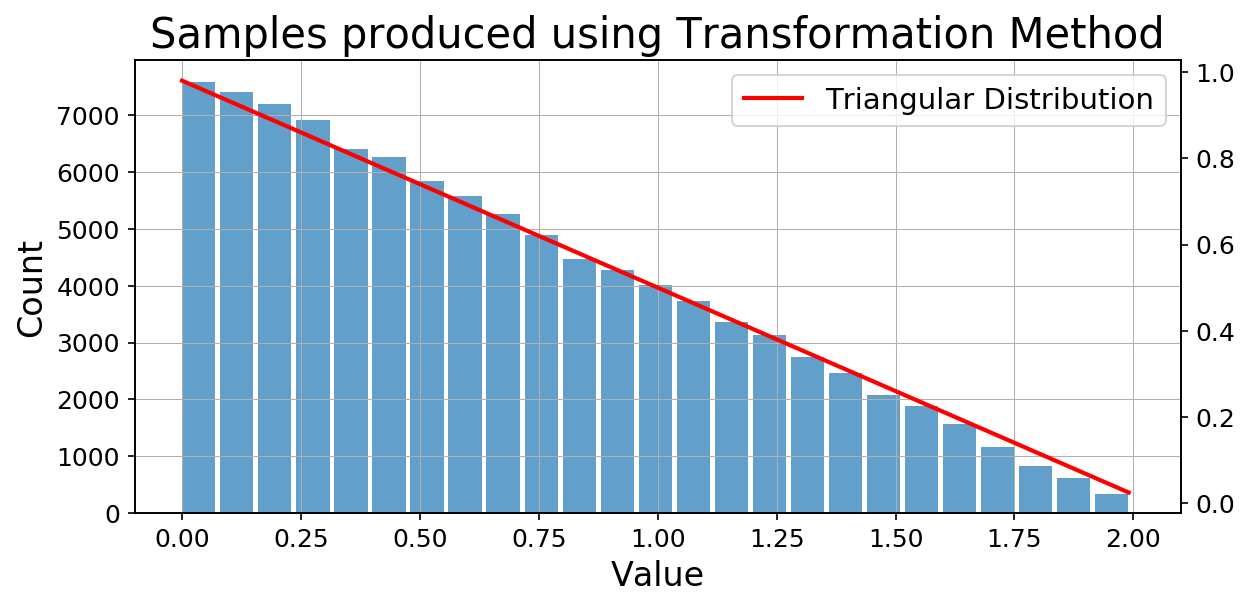

In [19]:
tri_pdf_samples = tri_transform(np.random.rand(100000), -0.48, 0.98)
x = np.arange(0, 2, 0.01)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(tri_pdf_samples, bins=25, width=0.07, alpha=0.7)
ax.set_title('Samples produced using Transformation Method')
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax1 = ax.twinx()
ax1.plot(x, P_tri(x), lw=2, color='red', label='Triangular Distribution')
ax1.set_xlabel('$P_{tri}(x)$')
ax1.legend()
ax1.yaxis.set_ticks(np.arange(0, 1.1, 0.2))
ax.grid()
plt.savefig('transform.png', bbox_inches='tight')
plt.show()

### Metropolis Algorithm Sampling Distribution

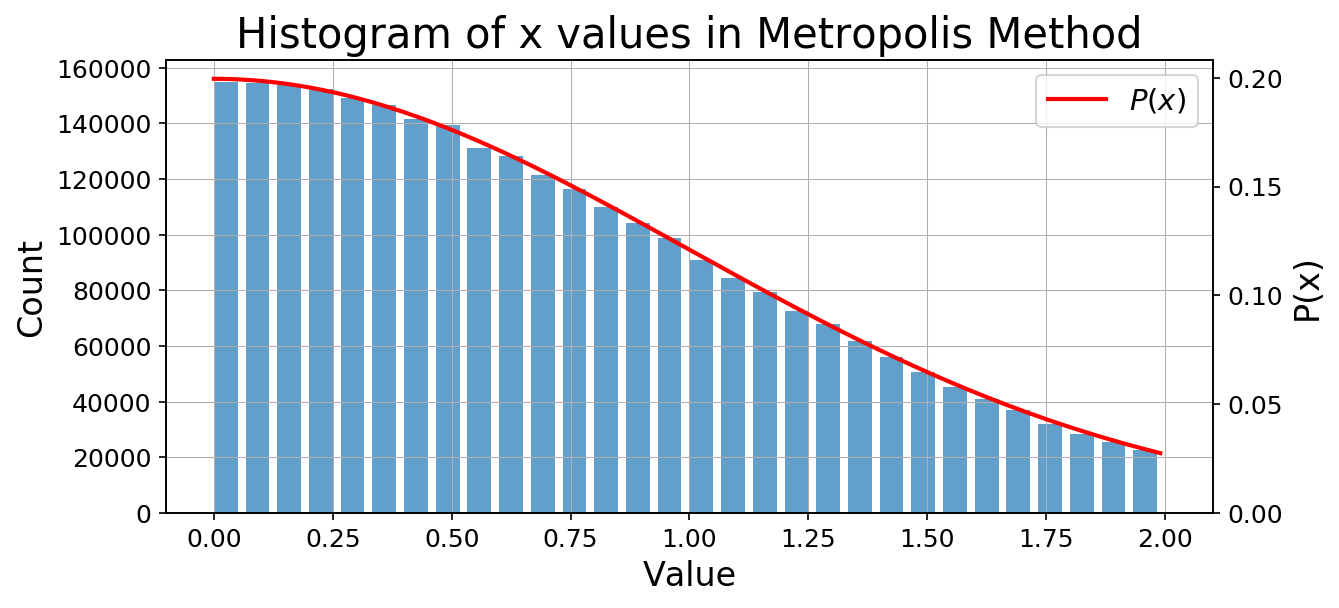

In [20]:
x = np.arange(0, 2, 0.01)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(met_x, bins=30, width=0.05, alpha=0.7)
ax.set_title('Histogram of x values in Metropolis Method')
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax1 = ax.twinx()
ax1.plot(x, psi_P(x), lw=2, color='red', label='$P(x)$')
ax1.set_ylabel('P(x)')
ax1.yaxis.set_ticks(np.arange(0, 0.21, 0.05))
ax1.legend()
ax.grid()
plt.savefig('met_x.png', bbox_inches='tight')
plt.show()